# Increases Sample Size

In [1]:
import tensorflow as tf
import tools.datasets.mnist3 as mnist_tools
import tools.datasets.svhn as svhn_tools
import tools.semisup as semisup
import numpy as np
import architectures as arch
from functools import partial

import tools.visualization as vis
import tools.updated_semisup as up

%load_ext autoreload
%autoreload 2

/home/frankzl/.envs/env36-ml/.venv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
mnist_train_images, mnist_train_labels = mnist_tools.get_data('train')
mnist_test_images, mnist_test_labels = mnist_tools.get_data('test')
svhn_train_images, svhn_train_labels = svhn_tools.get_data('train')
svhn_test_images, svhn_test_labels = svhn_tools.get_data('test')

Extracting /home/frankzl/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/frankzl/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/t10k-labels-idx1-ubyte.gz


In [3]:
# labeled samples used per class
# sup_per_class = 10
sup_per_class = 1280
sup_seed = -1
# labeled samples per class per batch
sup_per_batch = 128
# unlabeled samples per batch
unsup_batch_size = 2000
unsup_samples = 20000

learning_rate = 1e-4
decay_steps = 9000
decay_factor = 0.33
logit_weight = 1.0

max_steps = 2000
eval_interval = 500

log_dir = "logs/training/mnist-svhn-incr-batch/mnist-svhn"

seed = 1

IMAGE_SHAPE = mnist_tools.IMAGE_SHAPE
NUM_LABELS = mnist_tools.NUM_LABELS

# [10 (classes), 10 (samples), 28, 28, 1]
sup_by_label = semisup.sample_by_label(mnist_train_images, mnist_train_labels,
                        sup_per_class, NUM_LABELS, seed)

In [4]:
visit_weight_envelope = "linear"
visit_weight = 0.8
visit_weight_envelope_steps = 1
visit_weight_envelope_delay = 500
visit_weight_envelope_delay = 0

walker_weight_envelope = "linear"
#walker_weight = 2.0
walker_weight = 10.
walker_weight_envelope_steps = 1
walker_weight_envelope_delay = 500

TARGET_SHAPE = svhn_tools.IMAGE_SHAPE
TEST_SHAPE   = TARGET_SHAPE

image_shape = IMAGE_SHAPE
new_shape   = TARGET_SHAPE
emb_size    = 128

In [5]:
# Sample unlabeled training subset.
if unsup_samples > -1:
    num_unlabeled = len(svhn_train_images)
    assert unsup_samples <= num_unlabeled, (
        'Chose more unlabeled samples ({})'
        ' than there are in the '
        'unlabeled batch ({}).'.format(unsup_samples, num_unlabeled))

    rng = np.random.RandomState(seed=seed)
    choice = rng.choice(num_unlabeled, unsup_samples, False)
    sampled_unsup_images = svhn_train_images[choice]
    sampled_unsup_labels = svhn_train_labels[choice]
else:
    sampled_unsup_images = svhn_train_images
    sampled_unsup_labels = svhn_train_labels

In [6]:
from ipywidgets import IntProgress, Layout
from train import apply_envelope

graph = tf.Graph()

with graph.as_default():
    
    unsup_data = up.create_input(sampled_unsup_images, sampled_unsup_labels, unsup_batch_size)
    unsup_it   = unsup_data.make_initializable_iterator()
    
    t_unsup_images,t_unsup_labels = unsup_it.get_next()
    
    sup_data,sup_label = up.create_per_class_inputs_v2(sup_by_label, sup_per_batch)
    sup_it             = sup_data.repeat().make_one_shot_iterator()
    sup_it_label       = sup_label.repeat().make_one_shot_iterator()
    
    model_func = partial(
        arch.svhn_model,
        new_shape=new_shape,
        img_shape=image_shape,
        emb_size=emb_size
    )
    
    model = semisup.SemisupModel(model_func, NUM_LABELS, IMAGE_SHAPE,
                                 test_in=tf.placeholder(np.float32, [None] + TEST_SHAPE, 'test_in')
                                )
    
    t_sup_images, t_sup_labels = tf.concat( sup_it.get_next(), 0), tf.concat( sup_it_label.get_next(), 0)
    
    t_sup_emb   = model.image_to_embedding(t_sup_images)
    t_unsup_emb = model.image_to_embedding(t_unsup_images)
    
    t_sup_logit = model.embedding_to_logit(t_sup_emb)
    
    visit_weight = apply_envelope(
        type = visit_weight_envelope,
        step = model.step,
        final_weight = visit_weight,
        growing_steps = visit_weight_envelope_steps,
        delay = visit_weight_envelope_delay
    )
    
    walker_weight = apply_envelope(
        type = walker_weight_envelope,
        step = model.step,
        final_weight = walker_weight,
        growing_steps = walker_weight_envelope_steps,
        delay = walker_weight_envelope_delay
    )
    
    tf.summary.scalar("Weights_Visit", visit_weight)
    tf.summary.scalar("Weight_Walker", walker_weight)
    
    model.add_logit_loss(t_sup_logit, t_sup_labels, weight=logit_weight)
    
    #model.add_semisup_loss(t_sup_emb, t_unsup_emb, t_sup_labels, visit_weight=visit_weight, walker_weight=walker_weight)
    equality_matrix = tf.equal(tf.reshape(t_sup_labels, [-1, 1]), t_sup_labels)
    equality_matrix = tf.cast(equality_matrix, tf.float32)
    p_target = (equality_matrix / tf.reduce_sum(
        equality_matrix, [1], keepdims=True))

    multiple_semb = tf.constant([unsup_batch_size])
    multiple_uemb = tf.constant([sup_per_batch*NUM_LABELS])
    
    embedding_dim = t_sup_emb.shape[1]
    reshaped_semb = tf.reshape( t_sup_emb, [-1, 1, embedding_dim] )
    reshaped_uemb = tf.reshape( t_unsup_emb, [-1, 1, embedding_dim] )
    
    stacked_semb = tf.stack(unsup_batch_size*[t_sup_emb], 1)
    stacked_uemb = tf.stack(sup_per_batch*NUM_LABELS*[t_unsup_emb], 1)
    
    uemb_T = tf.transpose(stacked_uemb, perm=[1,0,2])
     
    sigma = 20
    pairwise_dist = (stacked_semb - uemb_T)#, axis=2)
    pairwise_norm = tf.norm( pairwise_dist, axis=2)
    pairwise_sq   = tf.square(pairwise_norm)
    
    match_ab   = tf.exp(- tf.divide( pairwise_sq, tf.constant(2*sigma**2, dtype=tf.float32)), name='match_ab')
    
    p_ab = tf.nn.softmax(match_ab, name='p_ab')
    p_ba = tf.nn.softmax(tf.transpose(match_ab), name='p_ba')
    p_aba = tf.matmul(p_ab, p_ba, name='p_aba')

    model.create_walk_statistics(p_aba, equality_matrix)
    
    loss_aba = tf.losses.softmax_cross_entropy(
        p_target,
        tf.log(1e-8 + p_aba),
        weights=walker_weight,
        scope='loss_aba')
    model.add_visit_loss(p_ab, visit_weight)

    tf.summary.scalar('Loss_aba', loss_aba)
    
    t_learning_rate = tf.train.exponential_decay(
        learning_rate,
        model.step,
        decay_steps,
        decay_factor,
        staircase = True
    )
    
    train_op = model.create_train_op(t_learning_rate)
    summary_op = tf.summary.merge_all()
    
    summary_writer = tf.summary.FileWriter(log_dir, graph)
    
    saver = tf.train.Saver(max_to_keep=30)

---------
Variables: name (type shape) [size]
---------
net/conv1/weights:0 (float32_ref 3x3x3x32) [864, bytes: 3456]
net/conv1/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_2/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_2/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_3/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_3/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv2_1/weights:0 (float32_ref 3x3x32x64) [18432, bytes: 73728]
net/conv2_1/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_2/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_3/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_3/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv3/weights:0 (float32_ref 3x3x64x128) [73728, bytes: 294912]
net/conv3/biases:0 (float32_ref 128) [128, bytes: 512]
net/conv3_2/weights:0 (float32_ref 3x3x128x128) [147456, bytes: 589824]
net/conv3_2/biases:

In [7]:
import time
import datetime

store_dir = "logs/training/mnist-svhn-incr-batch/mnist-svhn-visit"

In [ ]:
import time
import datetime

test_images = svhn_test_images[:2000]
test_labels = svhn_test_labels[:2000]


from IPython.display import display

max_steps = 1502
f = IntProgress(min=0, max=max_steps, layout= Layout(width="100%")) # instantiate the bar
display(f) # display the bar

sesh = tf.Session(graph = graph, config=tf.ConfigProto(intra_op_parallelism_threads=2, allow_soft_placement=True))

eval_interval = 100

p_aba_list = []
match_ab_list = []
t_sup_emb_list = []
t_unsup_emb_list = []


with sesh as sess:
    
    sess.run(unsup_it.initializer)
    sess.run(tf.global_variables_initializer())
    
    epoch = 0
    
    for step in range(0, max_steps):
        t0 = time.time()
        try:
            loss, _, summaries = sess.run([model.train_loss, train_op, summary_op])
        except tf.errors.OutOfRangeError:
            sess.run(unsup_it.initializer)
            epoch += 1
            
            loss, _, summaries = sess.run([model.train_loss, train_op, summary_op])
           
        f.value = step
        f.description = f"Ep{epoch}:{step}/{max_steps}"
        if (step) % eval_interval == 0:
            
            t1 = time.time()
            print(f"Time left: {datetime.timedelta(seconds=int((t1-t0)*(max_steps-step)))}s")
            
            print('Step: %d' % step)
            test_pred = model.classify(test_images).argmax(-1)
            conf_mtx = semisup.confusion_matrix(test_labels, test_pred, NUM_LABELS)
            test_err = (test_labels != test_pred).mean() * 100
            print(conf_mtx)
            print('Test error: %.2f %%' % test_err)
            print(f'Loss: {loss}')
            print()
    
            test_summary = tf.Summary(
                value=[tf.Summary.Value(
                    tag='Test Err', simple_value=test_err)])
    
            summary_writer.add_summary(summaries, step)
            summary_writer.add_summary(test_summary, step)

            print(f"saving model - step {step}")
            saver.save(sess, store_dir, global_step=model.step)

In [42]:
all_steps = list(range(1,1502,100))

p_aba_list = []
match_ab_list = []
p_ab_list = []
semb_list = []
uemb_list = []
slabel_list = []
ulabel_list = []

sup_img = []
unsup_img = []

for train_step in all_steps:
    model_checkpoint = f"{store_dir}-{train_step}"

    with tf.Session(graph=graph) as sess:
        
        saver = tf.train.Saver()
        saver.restore(sess, model_checkpoint)
        
        sess.run(unsup_it.initializer)
        
        supi, unsupi, pab, slabel, ulabel, ab, aba, semb, uemb = sess.run([t_sup_images, t_unsup_images, p_ab, t_sup_labels, t_unsup_labels, match_ab, p_aba, t_sup_emb, t_unsup_emb])
        sup_img.append(supi)
        unsup_img.append(unsupi)
        p_aba_list.append(aba)
        match_ab_list.append(ab)
        p_ab_list.append(pab)
        semb_list.append(semb)
        uemb_list.append(uemb)
        slabel_list.append(slabel)
        ulabel_list.append(ulabel)

INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn-incr-batch/mnist-svhn-visit-1
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn-incr-batch/mnist-svhn-visit-101
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn-incr-batch/mnist-svhn-visit-201
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn-incr-batch/mnist-svhn-visit-301
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn-incr-batch/mnist-svhn-visit-401
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn-incr-batch/mnist-svhn-visit-501
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn-incr-batch/mnist-svhn-visit-601
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn-incr-batch/mnist-svhn-visit-701
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn-incr-batch/mnist-svhn-visit-801
INFO:tensorflow:Restoring parameters from logs/training/mnist-svhn-incr-batch/mnist-svhn-visit-901
INFO:tensorf

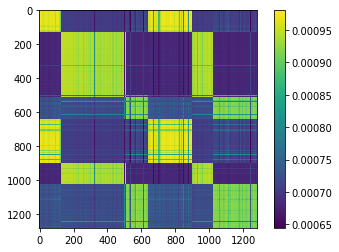

In [43]:
#my_match_ab = semb_list[-1] @ uemb_list[-1].T
idx = 15

import matplotlib.pyplot as plt
fig = plt.figure()
plt.imshow(p_aba_list[idx])

plt.colorbar()

In [30]:
sorted_uemb_list     = []
sorted_match_ab_list = []

from scipy.special import softmax

for idx in range(len(uemb_list)):
    sorted_uemb_list.append(uemb_list[idx][ulabel_list[idx].argsort()])
    sorted_match_ab_list.append(match_ab_list[idx][:,ulabel_list[idx].argsort()])

In [31]:
from ipywidgets import IntSlider, RadioButtons
from IPython.html.widgets import *
import matplotlib.pyplot as plt

def plot_img(array, step):
    if array == 0:
        a = p_aba_list
    elif array == 1:
        a = match_ab_list
    else:
        a = sorted_match_ab_list
            
    fig = plt.figure()
    plt.imshow(a[(step-1)//100])

interact(
    lambda step, array: plot_img(array, step),
    step = IntSlider(
        value=901,
        min=1,
        max=1501,
        step=100,
        description='Train Step',
        continuous_update=True,
        orientation='horizontal',
    ),
    array = RadioButtons(
        options=[('p_aba', 0), ("match_ab", 1), ("sorted_match_ab", 2)],
    )
)

/home/frankzl/.envs/env36-ml/.venv/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


interactive(children=(IntSlider(value=901, description='Train Step', max=1501, min=1, step=100), RadioButtons(…

<function __main__.<lambda>(step, array)>

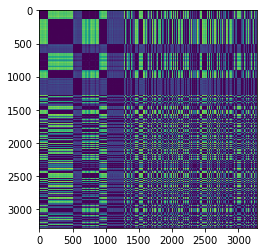

In [32]:
from tools.analyzer import Distance
import tools.analyzer as ana


idx = -1
stacked = np.vstack((semb_list[idx], uemb_list[idx][ulabel_list[idx].argsort()]))

similarity = ana.get_pairwise_distance(
  stacked, 
  Distance.l2)

import matplotlib.pyplot as plt
fig = plt.figure()

##plt.imshow(dot_similarity)
plt.imshow(similarity)

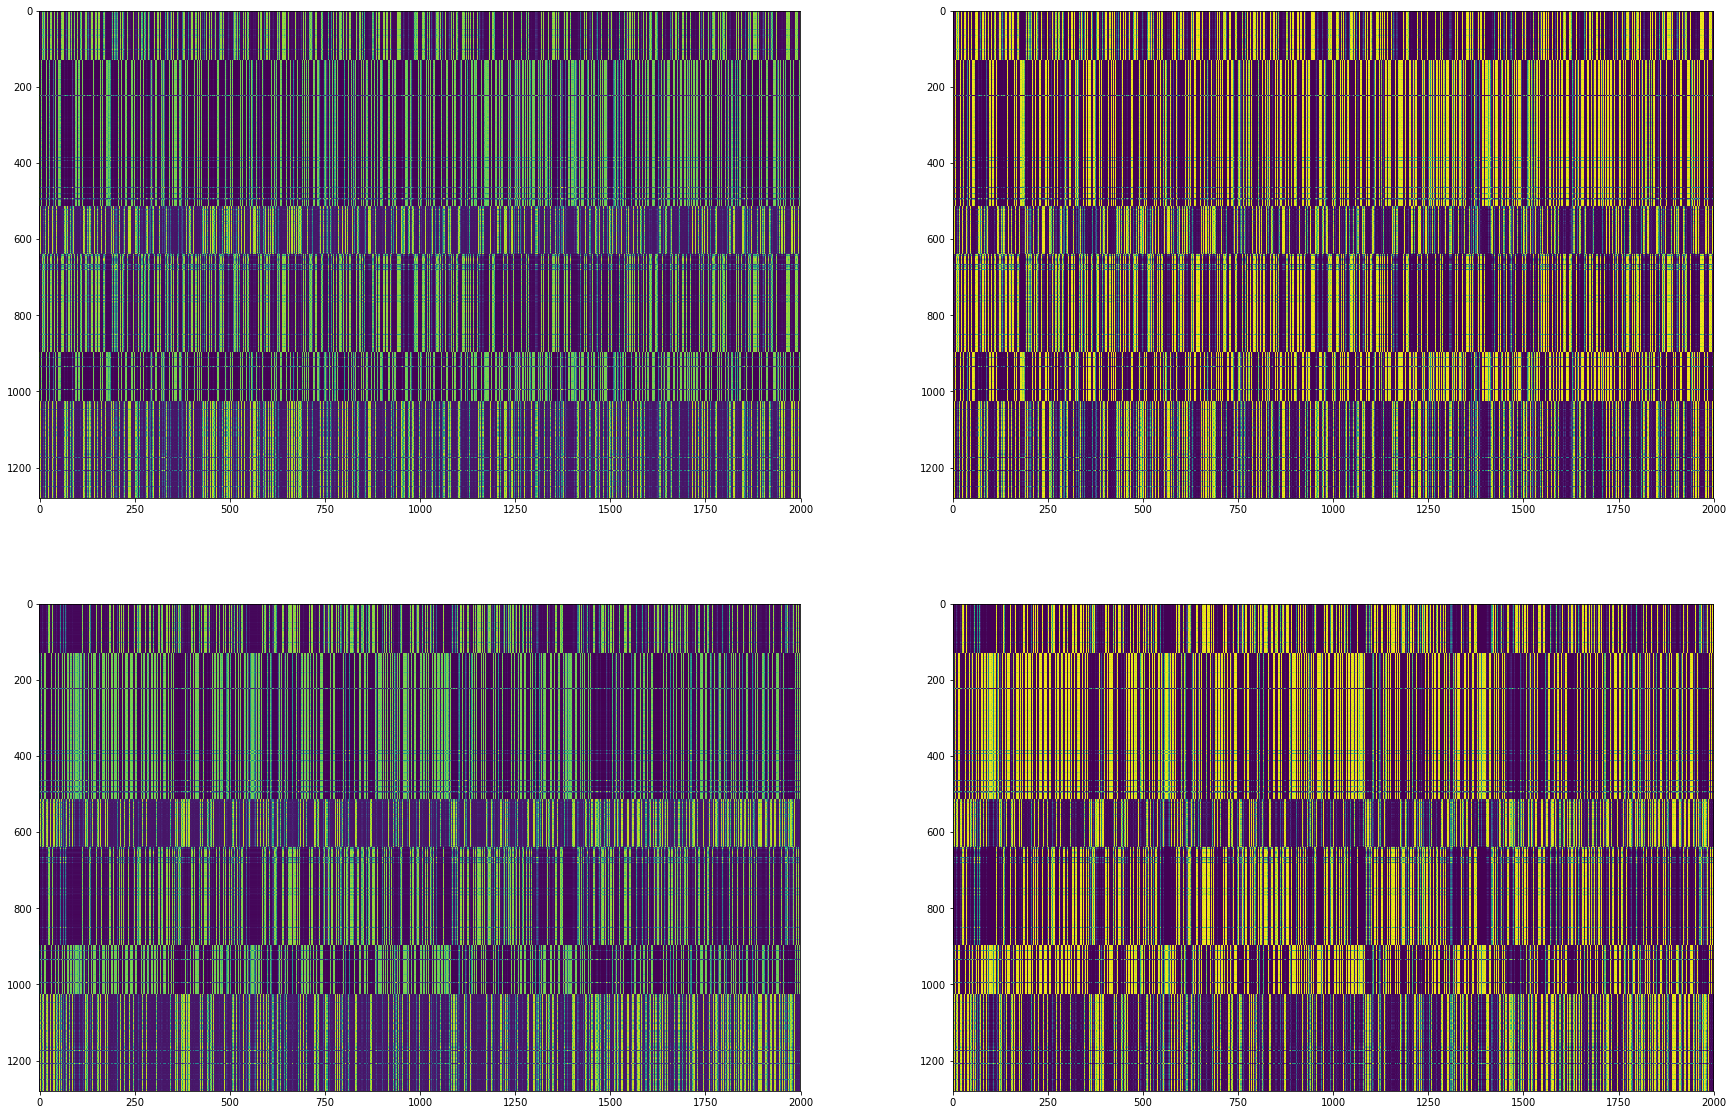

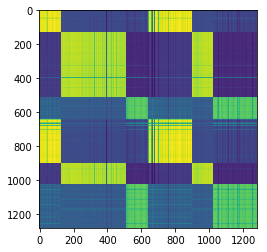

In [33]:
import numpy
from scipy.special import softmax

fig = plt.figure(figsize=(30,20))
my_match_ab = semb_list[-1] @ uemb_list[-1].T
my_p_ab     = softmax(my_match_ab, axis=1)

idx = -1

my_sorted_match_ab = semb_list[idx] @ uemb_list[idx][ulabel_list[idx].argsort()].T
my_sorted_p_ab     = softmax(my_sorted_match_ab, axis=1)

#my_match_ba = my_match_ab.T

my_p_aba = my_p_ab @ my_p_ab.T

plt.subplot(221)
plt.imshow(p_ab_list[idx]) 
fig = plt.subplot(222)
plt.imshow(match_ab_list[idx])
fig = plt.subplot(223)
plt.imshow(p_ab_list[idx][:,ulabel_list[idx].argsort()]) 
fig = plt.subplot(224)
plt.imshow(match_ab_list[idx][:,ulabel_list[idx].argsort()])
fig = plt.figure()
plt.imshow(p_aba_list[idx])

In [96]:
i = 500
largest_similarities = p_ab_list[-1][i] > 0.00085
sum(largest_similarities)

2

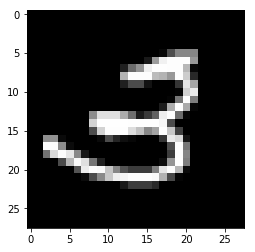

In [97]:
plt.imshow(sup_img[-1][i])

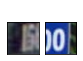

In [100]:
vis.imshow( unsup_img[-1][ largest_similarities ], imgwidth=32, channels=3, num_row=15 )

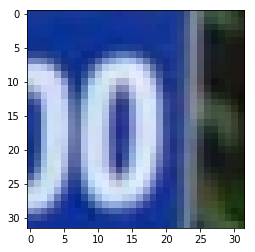

In [98]:
plt.imshow( unsup_img[-1][p_ab_list[-1][i].argmax()] )